# Tutorial - Ensemble - Regression


We will predict the price (`price` column) of an AirBNB listing in Boston given a number of features about the listing.

**Therefore, our unit of analysis is an AIRBNB LISTING**

# Setup

In [1]:
# Common imports
import numpy as np
import pandas as pd

np.random.seed(42)


# Get the data

In [2]:
#We will predict the "price" value in the data set:

airbnb = pd.read_csv("airbnb.csv")
airbnb.head()

,host_is_superhost,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,guests_included,price_per_extra_person,minimum_nights,number_of_reviews,number_days_btw_first_last_review,review_scores_rating,cancellation_policy,price,price_gte_150,price_category
0,0,0,Roslindale,42.282619,-71.133068,House,Entire home/apt,4,1.5,2.0,...,1,0,2,0,0,NaN,moderate,250,1,gte_226
1,0,1,Roslindale,42.286241,-71.134374,Apartment,Private room,2,1.0,1.0,...,0,0,2,36,804,94.0,moderate,65,0,lte_$75
2,1,1,Roslindale,42.292438,-71.135765,Apartment,Private room,2,1.0,1.0,...,1,20,3,41,2574,98.0,moderate,65,0,lte_$75
3,0,0,Roslindale,42.281106,-71.121021,House,Private room,4,1.0,1.0,...,2,25,1,1,0,100.0,moderate,75,0,lte_$75
4,1,1,Roslindale,42.284512,-71.136258,House,Private room,2,1.5,1.0,...,1,0,2,29,380,99.0,flexible,79,0,btw_$75-$150


# Split the data into train and test

In [3]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(airbnb, test_size=0.3)

### Be careful: we haven't seperated the target column yet

## Check the missing values

In [4]:
train_set.isna().sum()

host_is_superhost                      0
host_identity_verified                 0
neighbourhood_cleansed                 0
latitude                               0
longitude                              0
property_type                          2
room_type                              0
accommodates                           0
bathrooms                             10
bedrooms                               8
beds                                   6
bed_type                               0
Number of amenities                    0
guests_included                        0
price_per_extra_person                 0
minimum_nights                         0
number_of_reviews                      0
number_days_btw_first_last_review      0
review_scores_rating                 556
cancellation_policy                    0
price                                  0
price_gte_150                          0
price_category                         0
dtype: int64

In [5]:
test_set.isna().sum()

host_is_superhost                      0
host_identity_verified                 0
neighbourhood_cleansed                 0
latitude                               0
longitude                              0
property_type                          1
room_type                              0
accommodates                           0
bathrooms                              4
bedrooms                               2
beds                                   3
bed_type                               0
Number of amenities                    0
guests_included                        0
price_per_extra_person                 0
minimum_nights                         0
number_of_reviews                      0
number_days_btw_first_last_review      0
review_scores_rating                 244
cancellation_policy                    0
price                                  0
price_gte_150                          0
price_category                         0
dtype: int64

# Data Prep

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import FunctionTransformer

## Drop the variables we can't use in this tutorial

In [7]:
# We can't use the following columns in this tutorial, because they are for classification tasks

train = train_set.drop(['price_gte_150', 'price_category'], axis=1)
test = test_set.drop(['price_gte_150', 'price_category'], axis=1)

## Separate the target variable (we don't want to transform it)

In [8]:
train_y = train[['price']]
test_y = test[['price']]

train_inputs = train.drop(['price'], axis=1)
test_inputs = test.drop(['price'], axis=1)

## Feature Engineering: Let's derive a new column

### Inspect the `number of reviews` column

In [9]:
train_inputs['number_of_reviews'].describe()

count    2488.000000
mean       19.300241
std        36.080043
min         0.000000
25%         1.000000
50%         5.000000
75%        21.000000
max       320.000000
Name: number_of_reviews, dtype: float64

<Axes: >

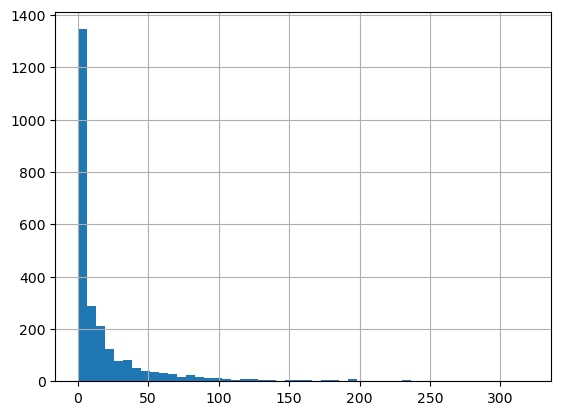

In [10]:
train_inputs['number_of_reviews'].hist(bins=50)

### Create a new ordinal column: convert the number of reviews to ordinal values.

In [11]:
def new_col(df):
    #Create a copy so that we don't overwrite the existing dataframe
    df1 = df.copy()
    
    df1['num_reviews_binned'] = pd.cut(df1['number_of_reviews'],
                                       bins=[0,0.5,1,6,10000],  #bins=[exclusive, inclusive]
                                       labels=False, 
                                       include_lowest=True,
                                       ordered=True)
    
#     You can also do this if you want categorical values:    
#     df1['num_reviews_binned'] = pd.cut(df1['number_of_reviews'],
#                                        bins=[0,0.5,1,5,15,50,10000], 
#                                        labels=['None','Very few','Few','Medium','Many','Too many'], 
#                                        include_lowest=True,
#                                        ordered=False)

    
    return df1[['num_reviews_binned']]
    # You can use this to check whether the calculation is made correctly:
    #return df1

In [12]:
#Let's test the new function:

# Send train set to the function we created
new_col(train_set)

,num_reviews_binned
1965,3
1450,3
2503,1
944,0
199,2
...,...
1130,3
1294,1
860,3
3507,0


In [13]:
#Check the new distribution

new_col(train_set).value_counts()

num_reviews_binned
3                     1143
2                      558
0                      517
1                      270
dtype: int64

##  Identify the numerical and categorical columns

In [14]:
train_inputs.dtypes

host_is_superhost                      int64
host_identity_verified                 int64
neighbourhood_cleansed                object
latitude                             float64
longitude                            float64
property_type                         object
room_type                             object
accommodates                           int64
bathrooms                            float64
bedrooms                             float64
beds                                 float64
bed_type                              object
Number of amenities                    int64
guests_included                        int64
price_per_extra_person                 int64
minimum_nights                         int64
number_of_reviews                      int64
number_days_btw_first_last_review      int64
review_scores_rating                 float64
cancellation_policy                   object
dtype: object

**At this stage, you can manually identify numeric, binary, and categorical columns as follows:**

`numeric_columns = ['latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'Number of amenities', 'guests_included', 'price_per_extra_person', 'minimum_nights', 'number_of_reviews', 'number_days_btw_first_last_review', 'review_scores_rating']`
 
 `binary_columns = ['host_is_superhost', 'host_identity_verified']`
 
 `categorical_columns = ['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type', 'cancellation_policy']`
 
<br>
 
**If you do not want to manually type these, you can do the below tricks:**

In [15]:
# Identify the numerical columns
numeric_columns = train_inputs.select_dtypes(include=[np.number]).columns.to_list()

# Identify the categorical columns
categorical_columns = train_inputs.select_dtypes('object').columns.to_list()

In [16]:
# Identify the binary columns so we can pass them through without transforming
binary_columns = ['host_is_superhost', 'host_identity_verified']

In [17]:
# Be careful: numerical columns already includes the binary columns,
# So, we need to remove the binary columns from numerical columns.

for col in binary_columns:
    numeric_columns.remove(col)

In [18]:
binary_columns

['host_is_superhost', 'host_identity_verified']

In [19]:
numeric_columns

['latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'Number of amenities',
 'guests_included',
 'price_per_extra_person',
 'minimum_nights',
 'number_of_reviews',
 'number_days_btw_first_last_review',
 'review_scores_rating']

In [20]:
categorical_columns

['neighbourhood_cleansed',
 'property_type',
 'room_type',
 'bed_type',
 'cancellation_policy']

In [21]:
feat_eng_columns = ['number_of_reviews']

# Pipeline

In [22]:
numeric_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [23]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [24]:
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

In [24]:
my_new_column = Pipeline(steps=[('my_new_column', FunctionTransformer(new_col)),
                               ('scaler', StandardScaler())])

In [25]:
preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns),
        ('binary', binary_transformer, binary_columns),
        ('trans', my_new_column, feat_eng_columns)],
        remainder='passthrough')

#passtrough is an optional step. You don't have to use it.

NameError: name 'numeric_transformer' is not defined

# Transform: fit_transform() for TRAIN

In [ ]:
#Fit and transform the train data
train_x = preprocessor.fit_transform(train_inputs)

train_x

In [26]:
train_x.shape

NameError: name 'train_x' is not defined

# Tranform: transform() for TEST

In [27]:
# Transform the test data
test_x = preprocessor.transform(test_inputs)

test_x

NameError: name 'preprocessor' is not defined

In [28]:
test_x.shape

NameError: name 'test_x' is not defined

# Calculate the baseline

In [31]:
from sklearn.dummy import DummyRegressor

dummy_regr = DummyRegressor(strategy="mean")

dummy_regr.fit(train_x, train_y)

DummyRegressor()

In [32]:
from sklearn.metrics import mean_squared_error

In [33]:
#Baseline Train RMSE
dummy_train_pred = dummy_regr.predict(train_x)

baseline_train_mse = mean_squared_error(train_y, dummy_train_pred)

baseline_train_rmse = np.sqrt(baseline_train_mse)

print('Baseline Train RMSE: {}' .format(baseline_train_rmse))

Baseline Train RMSE: 103.84299127618122


In [34]:
#Baseline Test RMSE
dummy_test_pred = dummy_regr.predict(test_x)

baseline_test_mse = mean_squared_error (test_y, dummy_test_pred)

baseline_test_rmse = np.sqrt(baseline_test_mse)

print('Baseline Test RMSE: {}' .format(baseline_test_rmse))

Baseline Test RMSE: 102.31125032666752


# Voting Regressor


In [54]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDRegressor 
from sklearn.svm import SVR 
from sklearn.ensemble import VotingRegressor


dtree_reg = DecisionTreeRegressor(max_depth=20)
svm_reg = SVR(kernel="rbf", C=10, epsilon=0.01, gamma='scale') 
sgd_reg = SGDRegressor(max_iter=10000, tol=1e-3)

voting_reg = VotingRegressor(
            estimators=[('dt', dtree_reg), 
                        ('svr', svm_reg), 
                        ('sgd', sgd_reg)])

voting_reg.fit(train_x, train_y)

C:\Users\mural\anaconda3\Lib\site-packages\sklearn\ensemble\_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


VotingRegressor(estimators=[('dt', DecisionTreeRegressor(max_depth=20)),
                            ('svr', SVR(C=10, epsilon=0.01)),
                            ('sgd', SGDRegressor(max_iter=10000))])

In [55]:
#Train RMSE
train_pred = voting_reg.predict(train_x)

train_mse = mean_squared_error(train_y, train_pred)

train_rmse = np.sqrt(train_mse)

print('Train RMSE: {}' .format(train_rmse))

Train RMSE: 43.01478922665345


In [56]:
#Test RMSE
test_pred = voting_reg.predict(test_x)

test_mse = mean_squared_error(test_y, test_pred)

test_rmse = np.sqrt(test_mse)

print('Test RMSE: {}' .format(test_rmse))

Test RMSE: 61.46427713866012


## Inspect each classifier

In [ ]:
for reg in (dtree_reg, svm_reg, sgd_reg, voting_reg):
    reg.fit(train_x, train_y['price'])
    test_y_pred = reg.predict(test_x)
    print(reg.__class__.__name__, 'Test rmse=', np.sqrt(mean_squared_error(test_y, test_y_pred)))

# Voting Regressor with weights

`weights` parameter allows you to put more weight on certain regressors than others

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDRegressor 
from sklearn.svm import SVR 
from sklearn.ensemble import VotingRegressor


dtree_reg = DecisionTreeRegressor(max_depth=20)
svm_reg = SVR(kernel="rbf", C=10, epsilon=0.01, gamma='scale') 
sgd_reg = SGDRegressor(max_iter=10000, tol=1e-3)

voting_reg = VotingRegressor(
            estimators=[('dt', dtree_reg), ('svr', svm_reg), ('sgd', sgd_reg)],
                        weights=[0.6, 0.2, 0.2])

voting_reg.fit(train_x, train_y)

In [ ]:
#Train RMSE
train_pred = voting_reg.predict(train_x)

train_mse = mean_squared_error(train_y, train_pred)

train_rmse = np.sqrt(train_mse)

print('Train RMSE: {}' .format(train_rmse))

In [ ]:
#Test RMSE
test_pred = voting_reg.predict(test_x)

test_mse = mean_squared_error(test_y, test_pred)

test_rmse = np.sqrt(test_mse)

print('Test RMSE: {}' .format(test_rmse))

# Bagging

In [ ]:
from sklearn.ensemble import BaggingRegressor


#If you want to do pasting, change "bootstrap=False"
#n_jobs=-1 means use all CPU cores
#bagging automatically performs soft voting

bag_reg = BaggingRegressor( 
            SGDRegressor(), n_estimators=50, 
            max_samples=1000, bootstrap=True, n_jobs=-1) 

bag_reg.fit(train_x, train_y)



In [ ]:
#Train RMSE
train_pred = bag_reg.predict(train_x)

train_mse = mean_squared_error(train_y, train_pred)

train_rmse = np.sqrt(train_mse)

print('Train RMSE: {}' .format(train_rmse))

In [ ]:
#Test RMSE
test_pred = bag_reg.predict(test_x)

test_mse = mean_squared_error(test_y, test_pred)

test_rmse = np.sqrt(test_mse)

print('Test RMSE: {}' .format(test_rmse))

## Random Patches

In [ ]:
#Random Patches: see the max_features variable
bag_reg = BaggingRegressor( 
            SGDRegressor(), n_estimators=50,  max_features=10,
            max_samples=1000, bootstrap=True, n_jobs=-1) 

bag_reg.fit(train_x, train_y)

In [ ]:
#Train RMSE
train_pred = bag_reg.predict(train_x)

train_mse = mean_squared_error(train_y, train_pred)

train_rmse = np.sqrt(train_mse)

print('Train RMSE: {}' .format(train_rmse))

In [ ]:
#Test RMSE
test_pred = bag_reg.predict(test_x)

test_mse = mean_squared_error(test_y, test_pred)

test_rmse = np.sqrt(test_mse)

print('Test RMSE: {}' .format(test_rmse))

## Random Subspaces

In [ ]:
#Random subspaces: see the max_samples variable
bag_reg = BaggingRegressor( 
            SGDRegressor(), n_estimators=50, max_features=10,
            max_samples=len(train_x), bootstrap=True, n_jobs=-1) 

bag_reg.fit(train_x, train_y)

In [ ]:
#Train RMSE
train_pred = bag_reg.predict(train_x)

train_mse = mean_squared_error(train_y, train_pred)

train_rmse = np.sqrt(train_mse)

print('Train RMSE: {}' .format(train_rmse))

In [ ]:
#Test RMSE
test_pred = bag_reg.predict(test_x)

test_mse = mean_squared_error(test_y, test_pred)

test_rmse = np.sqrt(test_mse)

print('Test RMSE: {}' .format(test_rmse))

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor 

rnd_reg = RandomForestRegressor(n_estimators=500, max_depth=10, n_jobs=-1) 

rnd_reg.fit(train_x, train_y)

In [ ]:
#Train RMSE
train_pred = rnd_reg.predict(train_x)

train_mse = mean_squared_error(train_y, train_pred)

train_rmse = np.sqrt(train_mse)

print('Train RMSE: {}' .format(train_rmse))

In [ ]:
#Test RMSE
test_pred = rnd_reg.predict(test_x)

test_mse = mean_squared_error(test_y, test_pred)

test_rmse = np.sqrt(test_mse)

print('Test RMSE: {}' .format(test_rmse))

# Extra-Trees

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor 

ext_reg = ExtraTreesRegressor(n_estimators=500, max_depth=10, n_jobs=-1) 

ext_reg.fit(train_x, train_y)

In [ ]:
#Train RMSE
train_pred = ext_reg.predict(train_x)

train_mse = mean_squared_error(train_y, train_pred)

train_rmse = np.sqrt(train_mse)

print('Train RMSE: {}' .format(train_rmse))

In [ ]:
#Test RMSE
test_pred = ext_reg.predict(test_x)

test_mse = mean_squared_error(test_y, test_pred)

test_rmse = np.sqrt(test_mse)

print('Test RMSE: {}' .format(test_rmse))

# AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostRegressor 


ada_reg = AdaBoostRegressor( 
            DecisionTreeRegressor(max_depth=10), n_estimators=500, 
            learning_rate=0.1) 

ada_reg.fit(train_x, train_y)

In [ ]:
#Train RMSE
train_pred = ada_reg.predict(train_x)

train_mse = mean_squared_error(train_y, train_pred)

train_rmse = np.sqrt(train_mse)

print('Train RMSE: {}' .format(train_rmse))

In [ ]:
#Test RMSE
test_pred = ada_reg.predict(test_x)

test_mse = mean_squared_error(test_y, test_pred)

test_rmse = np.sqrt(test_mse)

print('Test RMSE: {}' .format(test_rmse))

# Gradient Boosting

In [ ]:
#Use GradientBoosting

from sklearn.ensemble import GradientBoostingRegressor

gb_reg = GradientBoostingRegressor(max_depth=2, n_estimators=100, learning_rate=0.1) 

gb_reg.fit(train_x, train_y)

In [ ]:
#Train RMSE
train_pred = gb_reg.predict(train_x)

train_mse = mean_squared_error(train_y, train_pred)

train_rmse = np.sqrt(train_mse)

print('Train RMSE: {}' .format(train_rmse))

In [ ]:
#Test RMSE
test_pred = gb_reg.predict(test_x)

test_mse = mean_squared_error(test_y, test_pred)

test_rmse = np.sqrt(test_mse)

print('Test RMSE: {}' .format(test_rmse))

# Stochastic Gradient Boosting

In [ ]:
#Train on 75% of the sample only

gb_reg = GradientBoostingRegressor(max_depth=2, n_estimators=100, 
                                   learning_rate=0.1, subsample=0.75) 

gb_reg.fit(train_x, train_y)

In [ ]:
#Train RMSE
train_pred = gb_reg.predict(train_x)

train_mse = mean_squared_error(train_y, train_pred)

train_rmse = np.sqrt(train_mse)

print('Train RMSE: {}' .format(train_rmse))

In [ ]:
#Test RMSE
test_pred = gb_reg.predict(test_x)

test_mse = mean_squared_error(test_y, test_pred)

test_rmse = np.sqrt(test_mse)

print('Test RMSE: {}' .format(test_rmse))

# Selecting the number of estimators

In [ ]:
for x in range(1,30):
    gb_reg = GradientBoostingRegressor(max_depth=3, n_estimators=x, learning_rate=1.0) 
    gb_reg.fit(train_x, train_y['price'])
    
    train_pred = gb_reg.predict(train_x)
    test_pred = gb_reg.predict(test_x)
    
    train_rmse = np.sqrt(mean_squared_error(train_y, train_pred))
    test_rmse = np.sqrt(mean_squared_error(test_y, test_pred))
    
    print('# Estimators = {}'.format(x) + "     " + 'Train rmse = {}'.format(train_rmse) + "   "
         'Test rmse = {}'.format(test_rmse))

# Early Stopping

In [ ]:
#Notice that learning rate and tol are high to see early stopping
gb_reg = GradientBoostingRegressor(max_depth=2, n_estimators=100, 
                                   learning_rate=1, 
                                  tol=0.1, n_iter_no_change=5, validation_fraction=0.2,
                                  verbose=1) 

gb_reg.fit(train_x, train_y['price'])

In [ ]:
gb_reg.n_estimators_

In [ ]:
#Train RMSE
train_pred = gb_reg.predict(train_x)

train_mse = mean_squared_error(train_y, train_pred)

train_rmse = np.sqrt(train_mse)

print('Train RMSE: {}' .format(train_rmse))

In [ ]:
#Test RMSE
test_pred = gb_reg.predict(test_x)

test_mse = mean_squared_error(test_y, test_pred)

test_rmse = np.sqrt(test_mse)

print('Test RMSE: {}' .format(test_rmse))